In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

In [2]:
def read_atsp(url):
    
    '''
    Motivation: for some reason, the .atsp-file has 212 rows (not 53!). So,
    it needs to be manually processed.
    
    The function takes url (string) and returns a numpy array
    with edge costs.
    '''
    
    # Reads external file with numpy, 
    # spicifies the number of lines to skip,
    # initializes a lst to write to:  
    ds = np.DataSource()
    input_f = ds.open(url)
    num_lines_skip = 6
    lst = []
    
    # Appends each line to a list except for unuseful info:  
    for i, line in enumerate(input_f):
    
        if (i <= num_lines_skip) or ('EOF' in line):
            continue

        else:
            lst.append(line)

    # Concatenate each read line into one string,
    # removes all carriage returns and trailling whitespaces:  
    lst = ''.join(lst).replace('\n', '').split()
    
    # Return numpy array, reshape it into 53 x 53 matrix:  
    return np.array(lst, dtype=int).reshape(53, 53)

In [3]:
class CrossEntropyTSP(object):
    
    """Cross-entropy method for Traveling Salesman Problem.
    
    Citation:  
        De Boer, P-T., Kroese, D.P, Mannor, S. and Rubinstein, R.Y. (2005). 
        A Tutorial on the Cross-Entropy Method. Annals of Operations 
        Research, 134 (1), 19-67.
    
    Attributes:
        costs: A n x n numpy.array with costs of traveling from i to j city.
        c: An int. Used when one needs to increase the number of trials N.
        rho: A float which corresponds to the quantile of an empirical distribution.
        d: An int. Stopping parameter.
        alpha: A float indicates the smoothing parameter.
        seed: An int fixes the random state.
    
    """
    
    def __init__(self, costs, c, rho, d, alpha, seed):
        """Initializes the CrossEntropyTSP class."""
        self.costs = costs
        self.n = len(costs)
        self.N = c * self.n**2
        self.rho = rho
        self.d = d
        self.alpha = alpha
        self.random_state = np.random.RandomState(seed)
    
    def initTransitionMat(self):
        """Calculates a matrix where each element 1/(n-1) except for 
        diagonal elements."""
        p_ij = 1 / (self.n - 1)
        # Creates a matrix w/ shape like self.costs fills it
        # with values p_ij:  
        trans_mat = np.full_like(self.costs, p_ij, float)
        np.fill_diagonal(trans_mat, 0)
        # Reserves space not only for a new matrix but
        # also for a matrix from the previous iteration:  
        self.trans_mat = trans_mat
        self.trans_mat_old = trans_mat
        
        return None
    
    def generatePath(self):
        """Returns a list which contains a path from 0th 
        city to 0th city that includes other cities only 
        once. (Boer et. al, 2004, Algorithm 4.1)"""
        # Make the deep copy just to play it safe:
        trans_mat = self.trans_mat.copy()
        path = [0]

        for k in range(self.n-1):
            # We need to make the whole column to be 0 since
            # we do not want to come to it from another city:
            trans_mat[:, path[-1]] = 0
            row_sum = trans_mat.sum(axis=1)
            # The RuntimeWarrning ruined my verbosing. So I 
            # turned it off:
            with np.errstate(invalid='ignore', divide='ignore'):
                trans_mat = (trans_mat.T / row_sum).T
            # Select next city given probabilities:
            choice = self.random_state.choice(np.arange(self.n), p=trans_mat[path[-1], :])
            path.append(choice)
        
        # By the problem statement, we need to finish in the same city
        # where we started:
        path.append(0)
        
        return path
    
    def generatePaths(self):
        """Returns a list with N generated paths. (The for-comprehensions 
        are used here because they are faster.)"""
        return [self.generatePath() for _ in range(self.N)]
    
    def score(self, path):
        """Given path returns cost of the whole trip."""
        costs = []
        
        for k in range(len(path)-1):
            cost = self.costs[path[k], path[k+1]]
            costs.append(cost)
            
        return sum(costs)
    
    def calculateScoredPaths(self):
        """Calculates scored paths. A list of tuples
        (score, path)."""
        paths = self.generatePaths()
        # Fastly calculates scores for each path:  
        scores = list(map(self.score, paths))
        # Makes tuples (score, path):  
        scored_paths = list(zip(scores, paths))
        # Sorts paths according to scores [lowest, --, highest]:  
        self.scored_paths = sorted(scored_paths, key=lambda x: x[0])
        
        return None
    
    def gamma(self):
        """Returns gamma (rho-quantile score)."""
        rho_quantile_idx = int(self.rho * self.n**2)
        self.calculateScoredPaths()
        
        return self.scored_paths[rho_quantile_idx][0]
    
    def highestScore(self):
        """Just returns the highest score among all current paths."""
        
        return self.scored_paths[0][0]
    
    def Pmm(self):
        """Just returns 'the minimum of the maximum elements 
        in each row of the transition matrix'."""
        
        return self.trans_mat.max(axis=1).min()
    
    def highScoredPaths(self):
        """Returns a list with only high scored paths -- the ones that are
        scored lower than the rho-quantile path."""
        rho_quantile_idx = int(self.rho * self.N)
        
        return self.scored_paths[:rho_quantile_idx+1]
    
    def diffScoreRatio(self):
        """Returns a float indicating 'the proportion, out of N, of different
        values for the performance function'."""
        scores = [scored_path[0] for scored_path in self.scored_paths]
        diff_scores = len(set(scores))
        
        return diff_scores / self.N
    
    def smoothlyUpdateTransitionMat(self, alpha):
        """Smoothly updates current transition matrix and the previous one."""
        self.trans_mat_old = self.trans_mat.copy()
        trans_mat = np.zeros_like(self.trans_mat)
        
        # It is too slow to calculate according to 
        # (Boer et. al, 2004, Equation 49). Instead, we will use
        # a trick: increment each time there was a trip from
        # i to j by 1 and add it to a matrix. After that, 
        # we divide each element by a total number of selected paths:  
        for scored_path in self.highScoredPaths():
            
            for idx in range(self.n-1):
                i = scored_path[1][idx]
                j = scored_path[1][idx+1]
                trans_mat[i, j] += 1
        
        trans_mat = trans_mat / len(self.highScoredPaths())
        # Boer et. al (2004), Remark 3.3 (Smoothed Updating).
        self.trans_mat = alpha*trans_mat + (1-alpha)*self.trans_mat_old
        
        return None
    
    def shortestPath(self, verbose=True):
        """The main algorithm. Returns a path (list) with smallest achieved
        in this particular implementation given a specific random state.
        If verbose is True prints the progress and visualizes 
        transition matrices.
        """
        # Initialize matrix, lists, initial condition to enter 
        # the while-loop, and counter:  
        self.initTransitionMat()
        gammas = []
        highest_scores = []
        P_maxmins = []
        diff_scores = []
        while_cond = True
        t = 0
        
        if verbose:
            # Make the header for table and setting the figure size
            # for each transition matrix:  
            print('╔═════╦═════════╦═════════╦════════╦════════╗')
            print('║   t ║ Gamma_t ║  S_t(1) ║  Pmm_t ║ fdiff_t║')
            plt.figure(figsize=(10, 10));
        
        while while_cond:
            # Append informative values to corresponding lists:  
            gammas.append(self.gamma())
            highest_scores.append(self.highestScore())
            P_maxmins.append(self.Pmm())
            diff_scores.append(self.diffScoreRatio())
            
            # We need to have lists longer than d (stopping criterion)
            # to check the elif condition:  
            if t < self.d:
                while_cond = True
            
            # if the previous d gamma are the same exit the while-loop:  
            elif gammas[-self.d:] == [gammas[-1]] * self.d:
                while_cond = False
            
            if verbose:
                # Add the line to the 'verbose' table. I wanted the table to 
                # be useful when the number of cities will be much higher than
                # 53. So the gamma and highest score columns should be capable of 
                # holding a 7-digit number as well as t should hold a 3-digit 
                # number:  
                print('╠═════╬═════════╬═════════╬════════╬════════╣')
                print('║ {:3d} ║ {:7d} ║ {:7d} ║ {:05.4f} ║ {:05.4f} ║'.format(t, 
                                                                               gammas[-1], 
                                                                               highest_scores[-1], 
                                                                               P_maxmins[-1],
                                                                               diff_scores[-1]))
                # Also, draw the plots:  
                plt.matshow(self.trans_mat)
                plt.xlabel('j')
                plt.ylabel('i')
                plt.grid('off')
                plt.colorbar()
            
            # Update the transition matrices (new and old) and increment t:  
            self.smoothlyUpdateTransitionMat(alpha=self.alpha)
            t += 1
            
        if verbose:
            # Finish the 'verbose' table and plot matrices:  
            print('╚═════╩═════════╩═════════╩════════╩════════╝')
            plt.show();
        
        return self.scored_paths[0][1]

In [4]:
# Load the data:  
url = 'http://elib.zib.de/pub/mp-testdata/tsp/tsplib/atsp/ft53.atsp'
ft53 = read_atsp(url)

╔═════╦═════════╦═════════╦════════╦════════╗
║   t ║ Gamma_t ║  S_t(1) ║  Pmm_t ║ fdiff_t║
╠═════╬═════════╬═════════╬════════╬════════╣
║   0 ║   22061 ║   19982 ║ 0.0192 ║ 0.1916 ║
╠═════╬═════════╬═════════╬════════╬════════╣
║   1 ║   19548 ║   18708 ║ 0.0307 ║ 0.2224 ║
╠═════╬═════════╬═════════╬════════╬════════╣
║   2 ║   17466 ║   16142 ║ 0.0383 ║ 0.2287 ║
╠═════╬═════════╬═════════╬════════╬════════╣
║   3 ║   15776 ║   14705 ║ 0.0483 ║ 0.2197 ║
╠═════╬═════════╬═════════╬════════╬════════╣
║   4 ║   14513 ║   13744 ║ 0.0593 ║ 0.2125 ║
╠═════╬═════════╬═════════╬════════╬════════╣
║   5 ║   13168 ║   12405 ║ 0.0677 ║ 0.2043 ║
╠═════╬═════════╬═════════╬════════╬════════╣
║   6 ║   12294 ║   11280 ║ 0.0775 ║ 0.1976 ║
╠═════╬═════════╬═════════╬════════╬════════╣
║   7 ║   11609 ║   11036 ║ 0.0817 ║ 0.1917 ║
╠═════╬═════════╬═════════╬════════╬════════╣
║   8 ║   11052 ║   10000 ║ 0.0768 ║ 0.1847 ║
╠═════╬═════════╬═════════╬════════╬════════╣
║   9 ║   10431 ║    9527 ║ 0.0973

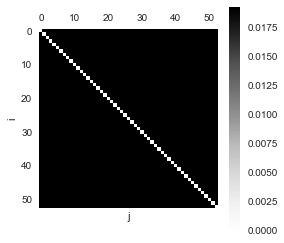

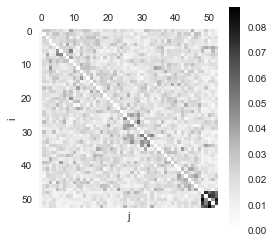

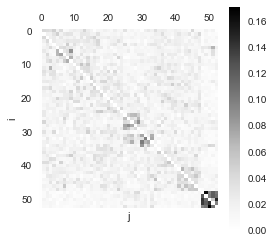

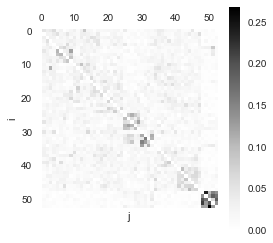

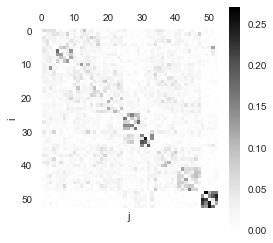

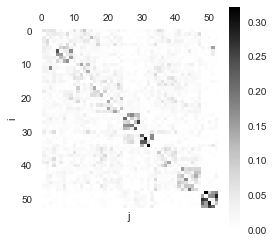

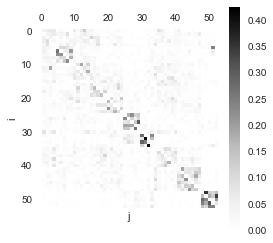

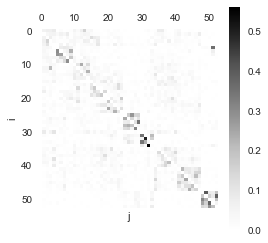

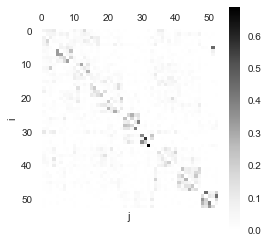

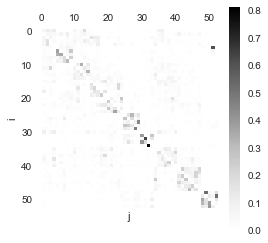

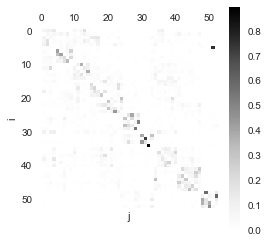

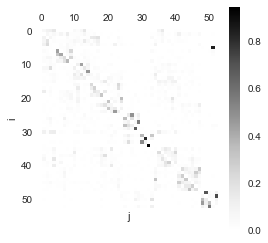

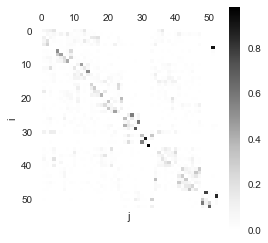

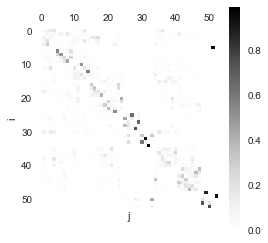

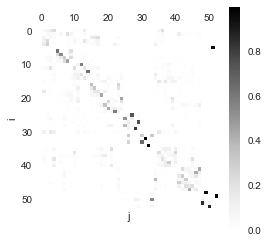

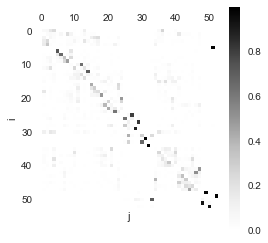

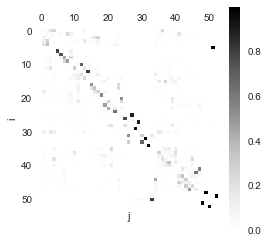

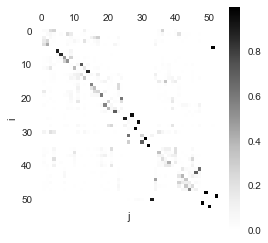

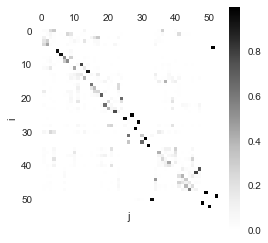

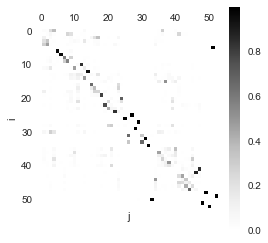

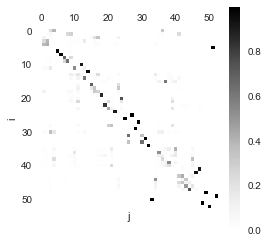

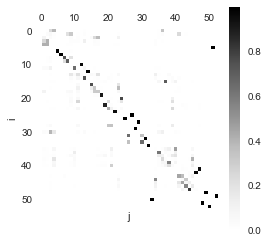

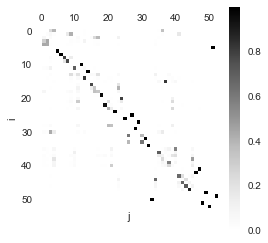

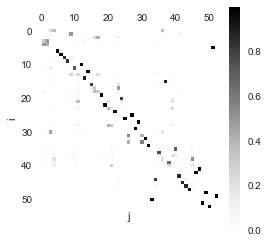

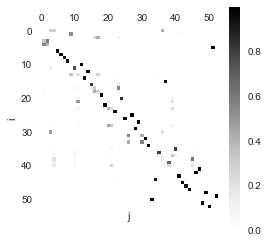

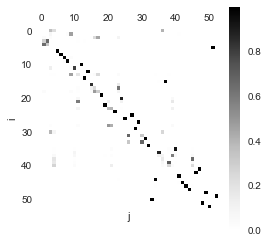

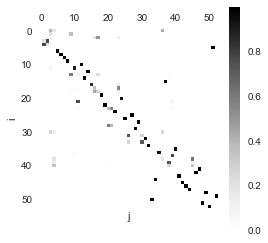

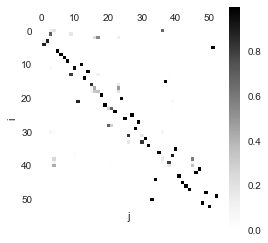

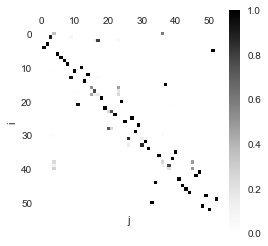

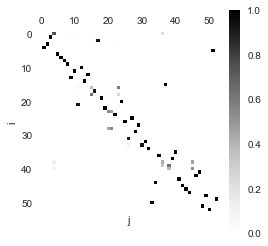

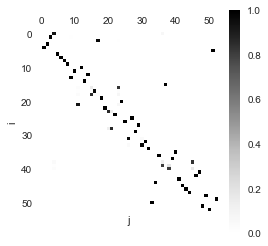

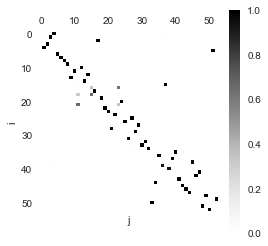

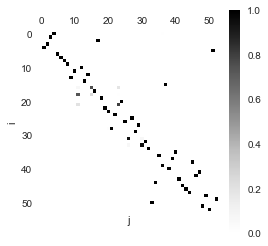

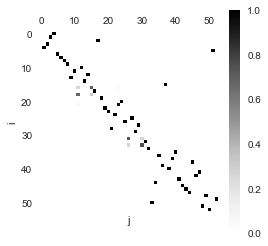

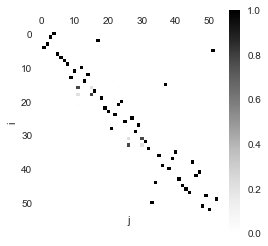

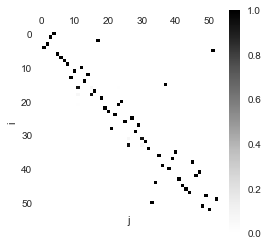

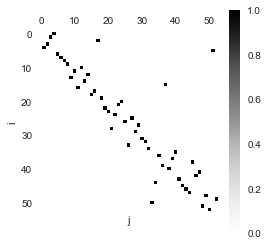

[0,
 4,
 1,
 3,
 2,
 17,
 16,
 11,
 10,
 12,
 14,
 13,
 9,
 8,
 7,
 6,
 5,
 51,
 48,
 49,
 52,
 50,
 33,
 26,
 25,
 27,
 29,
 28,
 21,
 23,
 20,
 24,
 22,
 19,
 18,
 15,
 37,
 39,
 36,
 35,
 40,
 38,
 45,
 42,
 46,
 43,
 41,
 47,
 44,
 34,
 32,
 31,
 30,
 0]

In [5]:
# Run the optimization. It takes almost an hour 
# to run on my computer. Consider to reduce c to 1 
# to speed up a bit:  
CE = CrossEntropyTSP(costs=ft53, c=10, rho=0.01, d=5, alpha=0.7, seed=13)
CE.shortestPath(verbose=True)